# Word Embeddings

Word2Vec Model based on TensorFlow's Word2Vec tutorial.

Tutorial: https://www.tensorflow.org/tutorials/word2vec

Source code: https://github.com/tensorflow/tensorflow/blob/r1.8/tensorflow/examples/tutorials/word2vec/word2vec_basic.py

The most common solution to come up with the most meaningful representation of a word is to represent each word in the vocabulary using a fairly small and dense vector (e.g., 150 dimensions). 

# Step 0: Imports

In [1]:
import collections
import math
import os  # So we can grab the files
import errno
import random
import zipfile  # So we can unzip the files

import numpy as np
from six.moves import urllib
from six.moves import xrange
import tensorflow as tf

# Step 1: Fetch the data

In [2]:
words_dir = "word2vec_data/words"
words_url = "http://mattmahoney.net/dc/text8.zip"

def mkdir_p(path):
    """Creates a directorie if it does not exist.
    Equivalent to 'mkdir -p' but for Python
    
    This is for python 2 support. In python >= 3.2, simply use:
    >>> os.makedirs(path, exist_ok=True)
    """
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

def fetch_words_data(url=words_url, data_dir = words_dir):
    
    # Make the Dir if it does not exist
    os.makedirs(data_dir, exist_ok=True)
    
    # Path to zip file 
    zip_path = os.path.join(data_dir, "words.zip")
    
    # If the zip file isn't there, download it from the url
    if not os.path.exists(zip_path):
        #Need priveldges to download or else an error will be thrown
        urllib.request.urlretrieve(url, zip_path) 
        
    # Now that the zip file is there, get the data from it
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0]) #Reads in the data
    
    # Return a list of all the words in the data source.
    return data.decode("ascii").split()

In [3]:
# This data is quite large so it may take a while
words = fetch_words_data()

In [4]:
# Total number of words
len(words)

17005207

In [5]:
words[655874:655900]

['character',
 'recognition',
 'handwriting',
 'recognition',
 'speech',
 'recognition',
 'face',
 'recognition',
 'natural',
 'language',
 'processing',
 'translation',
 'and',
 'chatterbots',
 'non',
 'linear',
 'control',
 'and',
 'robotics',
 'computer',
 'vision',
 'virtual',
 'reality',
 'and',
 'image',
 'processing']

In [6]:
# Sentence of above words
for word in words[655874:655900]:
    print(word, end = " ")

character recognition handwriting recognition speech recognition face recognition natural language processing translation and chatterbots non linear control and robotics computer vision virtual reality and image processing 

## Building Word Counts

In [7]:
# Building a word count using the collections library
from collections import Counter

In [8]:
# Example of counter
arr = ["one", "two", "three", "three"]
Counter(arr)

Counter({'one': 1, 'three': 2, 'two': 1})

In [9]:
Counter(arr).most_common(1) #Returns the number 1 most common word 

[('three', 2)]

In [10]:
Counter(arr).most_common(2) #Returns the 2 most common words

[('three', 2), ('one', 1)]

# Step 3: Building the dictionary of word data and vocab

In [11]:
# Assuming the vocabulary list has around 50,000 unique words
def build_counts(vocab_size=50000):
    """Process inputs into a dataset"""
    # If wanted, replace rare words with UNK token.
    
    # Adds vocab counts with Counter
    vocabulary = [] + Counter(words).most_common(vocab_size)
    
    # Turns it into a numpy array
    vocabulary = np.array([word for word, _ in vocabulary])
    
    # Reverses the dictionary
    dictionary = {word:code for code, word in enumerate(vocabulary)} 
    data = np.array([dictionary.get(word, 0) for word in words])
    return data,vocabulary

In [12]:
data,vocab = build_counts()

In [13]:
# .shape returns a tuple of array dimensions
data.shape

(17005207,)

In [14]:
vocab.shape

(50000,)

In [15]:
# The value at index 123 in words
words[123]

'word'

In [16]:
# Returns what number vocab word it is
data[123]

247

# Step 4: Generate batches
Function is from the word2vec file from the TensorFlow Docs

In [17]:
# This function will be used to generate batches to use during training 
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
    if data_index == len(data):
        buffer[:] = data[:span]
        data_index = span
    else:
        buffer.append(data[data_index])
        data_index += 1
  # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

# Step 5: Building the model

### Constants

In [18]:
# Size of the batch
batch_size = 128

# Dimenesion of the embedding vector 
# The more dimenensions the more information but the longer the training
embedding_size = 150 

# How many words to consider to the left and to the right
# The bigger the value the longer the training
skip_window = 1

# How many times to reuse an input to generate a label
num_skips = 2

In [19]:
# We need to pick a random validation set to sample nearest neighbors. 

# This is a random set of words to evaluate similarity on.
valid_size = 16

# Only pick samples from the head of the distribution 
valid_window = 100 
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

# Here we are limiting the validation samples to the words that have a low numeric ID,
# which by the way we constructed these they are also the most frequent words.

In [20]:
# Number of negative examples to sample.
num_sampled = 64   

# Model Learning Rate
# Small learning rates will take a long time
learning_rate = 0.01

# How many words in the vocabulary
vocabulary_size = 50000

## TensorFlow Placeholders and Constants

In [21]:
tf.reset_default_graph()

# Input data

# Shape is none because it is defined by the batch
train_inputs = tf.placeholder(tf.int32, shape=[None])  
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

### Variables

In [22]:
# Look up embeddings for inputs.
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)

# Matrix where each row represents a word vector
embeddings = tf.Variable(init_embeds)  

embed = tf.nn.embedding_lookup(embeddings, train_inputs)

### NCE Loss

In [23]:
# A faster alternative to softmax method

# Create these two variables for NCE Loss
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

In [24]:
# Computing the average NCE Loss for the batch 
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(tf.nn.nce_loss
                      (nce_weights, nce_biases, train_labels, embed,num_sampled, vocabulary_size))

### Optimizer 

In [25]:
# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=1.0)
trainer = optimizer.minimize(loss)

In [26]:
# Computes the cosine similarity between minibatch examples and all embeddings.
# From documentation example
# Creates normalized embeedings 
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

In [27]:
# Global variable called by batch generator 
data_index = 0

In [28]:
# Add variable initializer.
init = tf.global_variables_initializer()

# Step 6: Training the model

In [29]:
# To prevent TensorFlow from allocating almost 100% of the GPU 
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

In [30]:
# Usually needs to be quite large to get good results, 
# Training takes a long time!
num_steps = 5000

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    
    sess.run(init)
    average_loss = 0
    
    for step in range(num_steps):
         
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}  # For the placeholders of train inputs

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        _, loss_val = sess.run([trainer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 1000 == 0:
            if step > 0:
                average_loss /= 1000
            # The average loss is an estimate of the loss over the last 1000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

    final_embeddings = normalized_embeddings.eval()

Average loss at step  0 :  273.655212402
Average loss at step  1000 :  10630.1708104
Average loss at step  2000 :  23116.1113765
Average loss at step  3000 :  26247.0122348
Average loss at step  4000 :  33171.0060103


# Step 7: Visualize the embeddings

## TSNE
Source of alogrithm
-  https://lvdmaaten.github.io/tsne/
-  https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding

It provides dimensionality reduction to 2-D vectors from higher dimensional datasets

In [33]:
type(final_embeddings)

numpy.ndarray

In [34]:
final_embeddings.shape

(50000, 150)

In [35]:
# Transforming 150 dimensions to 2 will take awhile
from  sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

In [36]:
plot_only = 500

In [37]:
low_dim_embeds = tsne.fit_transform(final_embeddings[:plot_only,:])

In [39]:
labels = [vocab[i] for i in range(plot_only)]

In [40]:
low_dim_embeds.shape

(500, 2)

## Plots the embeddings 

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
# Creates scatterplot with labels
# Function to draw visualization of distance between embeddings. From source code
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

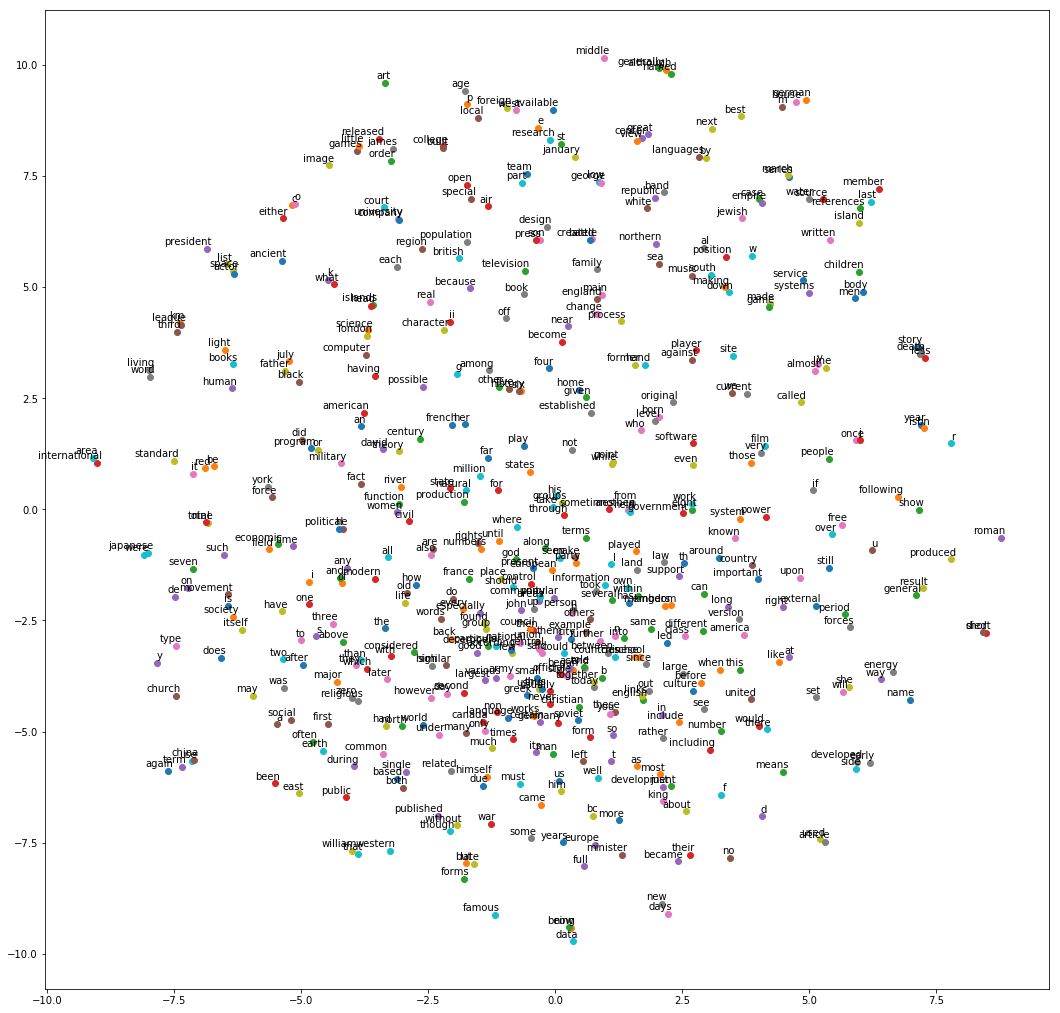

In [43]:
plot_with_labels(low_dim_embeds, labels)

We can save the final embeddings (Alternatively one can use TensorFlow Saver)

In [44]:
np.save("./my_final_embeddings.npy", final_embeddings)